In [1]:
from src.capstone.evaluation import Evaluator
from src.capstone.cbf import CBF
from src.capstone.settings import Env
from src.capstone.noise import DoubleIntegratorEnv

from bound_propagation.parallel import Parallel
from bound_propagation.bivariate import Mul
from bound_propagation.reshape import Select
from bound_propagation.polynomial import UnivariateMonomial, Pow
from bound_propagation.linear import FixedLinear
from bound_propagation.activation import Sin

import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn

import math
import matplotlib.pyplot as plt



/Users/wesselwolterbeekmuller/Documents/Documents - Wessel’s MacBook Pro/Studie/Engineering with AI/Capstone/SCBF Paper/Capstone/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


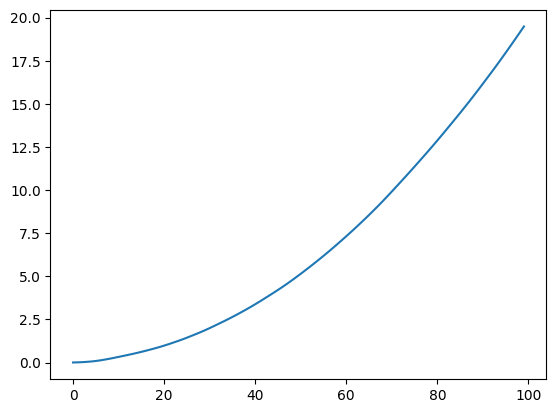

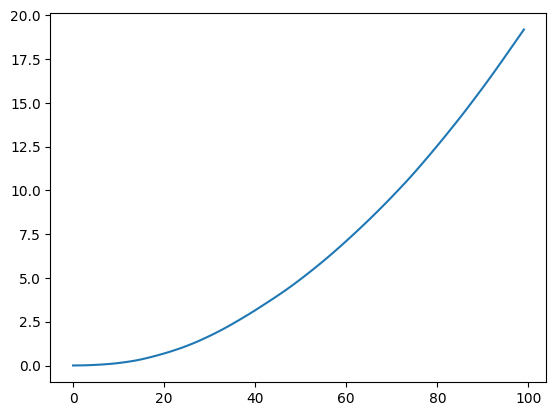

In [10]:
env = DoubleIntegratorEnv()
env.reset()
action = np.array([[1.5, 1.5]])

x_list = []
y_list = []
ts = []
for t in range(100):
    state = env.step(action)

    x = state[0][0][0].item()
    y = state[0][0][1].item()

    x_dot = state[0][0][2].item()
    y_dot = state[0][0][3].item()

    x_list.append(x)
    y_list.append(y)
    ts.append(t)

plt.plot(ts, y_list)
plt.show()
plt.plot(ts, x_list)

In [3]:
class NNDM(nn.Sequential):
    # input [x pos, y pos, x speed, y speed, ux, uy]
    
    def __init__(self):
        super(NNDM, self).__init__()
        self.dt = 0.05
        self.layer1 = nn.Linear(6, 4, bias=False)
        self.weights = torch.tensor([[1., 0., self.dt, 0., ((self.dt**2)/2), 0], 
                                     [0., 1., 0., self.dt, 0., ((self.dt**2)/2)], 
                                     [0., 0., 1., 0., self.dt, 0.], 
                                     [0., 0., 0., 1., 0., self.dt]])
        self.layer1.weight = nn.Parameter(self.weights)
        self.model = nn.Sequential(
            self.layer1
        )
    def forward(self, input):
        return self.model(input)

nndm = NNDM()
nndm(torch.tensor([[1., 1., 1., 1., 1., 1.]]))


tensor([[1.0512, 1.0512, 1.0500, 1.0500]], grad_fn=<MmBackward0>)

In [4]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        
        self.layer = nn.Linear(2, 2)
        
        # dummy output of u=0
        self.layer.weight = nn.Parameter(torch.tensor([[0., 0., 0., 0.], [0., 0., 0., 0.]]))
        self.layer.bias = nn.Parameter(torch.tensor([50., 0.]))
    
    def forward(self, x):
        return self.layer(x)
    
    def select_action(self, x, exploration=False):
        if exploration:
            raise ValueError('This model is not implemented for exploration')
        else:
            return self.forward(x)

In [5]:
policy = Agent()



In [6]:
class DoubleIntegrator(Env):
    def __init__(self):
        self.is_discrete = False
        
        self.settings = {
            'noise': [],
            'max_frames': 100
        }
        
        self.h_function = nn.Sequential(
            FixedLinear(
                torch.tensor([
                    [1., 0, 0, 0],
                    [0, 1, 0, 0]
                ]),
                torch.tensor([0., 0.])
            ),
            Pow(2),
            FixedLinear(
                torch.tensor([
                    [-1 / 0.5 ** 2, 0],
                    [0, -1 / 0.5 ** 2]
                ]),
                torch.tensor([1., 1.])
            )
        )

        self.h_ids = [0, 1]
        self.std = [0.0, 0.0]
        self.env = DoubleIntegratorEnv()

In [7]:
env = DoubleIntegrator()

In [8]:
cbf = CBF(env, nndm, policy,
          alpha=[0.9, 0.9],
          delta=[0., 0.],
          no_action_partitions=2,
          no_noise_partitions=2,
          stochastic=True)

/Users/wesselwolterbeekmuller/Documents/Documents - Wessel’s MacBook Pro/Studie/Engineering with AI/Capstone/SCBF Paper/Capstone/src/capstone/cbf.py:136: RuntimeWarning: invalid value encountered in scalar multiply
  dim_lower_bound = action_low[dimensions] + part * partition_size
/Users/wesselwolterbeekmuller/Documents/Documents - Wessel’s MacBook Pro/Studie/Engineering with AI/Capstone/SCBF Paper/Capstone/src/capstone/cbf.py:136: RuntimeWarning: invalid value encountered in scalar add
  dim_lower_bound = action_low[dimensions] + part * partition_size


In [9]:
evaluator = Evaluator(env, cbf)
f, h = evaluator.mc_simulate(policy, 100, cbf_enabled=True, seed=[0.1, 0.])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/Users/wesselwolterbeekmuller/Documents/Documents - Wessel’s MacBook Pro/Studie/Engineering with AI/Capstone/SCBF Paper/Capstone/env/lib/python3.11/site-packages/bound_propagation/linear.py", line 33, in ibp_forward_linear_jit
    weight = weight.transpose(-1, -2)

    w_mid = center.matmul(weight)
            ~~~~~~~~~~~~~ <--- HERE
    if bias is not None:
        w_mid = w_mid + bias.unsqueeze(-2)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4 and 6x4)
